In [1]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import pytest
import numpy as np
import numpy.testing as npt
from NuMPI.Tools.Reduction import Reduction
from ContactMechanics import FreeFFTElasticHalfSpace
from SurfaceTopography import make_sphere
from ContactMechanics.Systems import NonSmoothContactSystem
from ContactMechanics.ReferenceSolutions import Hertz as Hz

import scipy.optimize as optim
from math import isnan, sqrt

In [78]:
# sphere radius:
r_s = 3.0
# equivalent Young's modulus
E_s = 1.
nx, ny = (16,16)
#for disp0, normal_force in [(0.1, None), (0, 15.0)]:
disp0 = .1
normal_force = 0.
sx = 6.0

substrate = FreeFFTElasticHalfSpace((nx, ny), E_s, (sx, sx))
                                    #fft='mpi',
                                    #communicator=comm)
#print(substrate.)
surface = make_sphere(
    r_s, (nx, ny), (sx, sx),
    nb_subdomain_grid_pts=substrate.topography_nb_subdomain_grid_pts,
    subdomain_locations=substrate.topography_subdomain_locations)
    #communicator=substrate.communicator)
# system = NonSmoothContactSystem(substrate, surface)

result = constrained_conjugate_gradients(substrate=substrate, topography=surface, offset=disp0,
                                external_force=normal_force)


[[1.95591792e-05 2.21739261e-05 2.53212990e-05 ... 1.45978438e-05
  1.58226987e-05 1.74580693e-05]
 [2.21739261e-05 2.58877935e-05 3.05791072e-05 ... 1.55735013e-05
  1.71498930e-05 1.93082757e-05]
 [2.53212990e-05 3.05791072e-05 3.76013720e-05 ... 1.66243798e-05
  1.86271066e-05 2.14443745e-05]
 ...
 [1.45978438e-05 1.55735013e-05 1.66243798e-05 ... 1.24221580e-05
  1.30048859e-05 1.37341017e-05]
 [1.58226987e-05 1.71498930e-05 1.86271066e-05 ... 1.30048859e-05
  1.37410782e-05 1.46812350e-05]
 [1.74580693e-05 1.93082757e-05 2.14443745e-05 ... 1.37341017e-05
  1.46812350e-05 1.59169121e-05]]


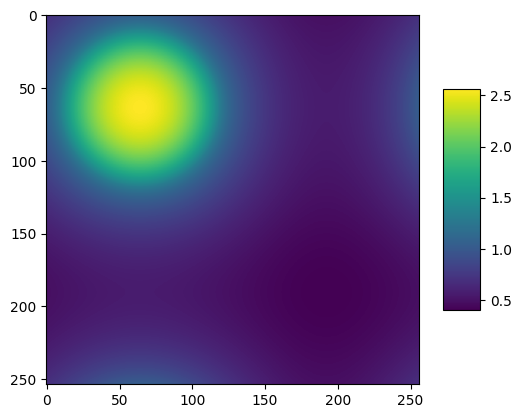

In [ ]:
"""disp = result.x
forces = -result.jac
converged = result.success
assert converged"""
#result.x.shape
fig, ax = plt.subplots()
surf = ax.imshow(result.x[:512,:512])
plt.colorbar(surf, shrink=0.6, aspect=6)

In [76]:
def constrained_conjugate_gradients(substrate, topography, hardness=None,
                                    external_force=None, offset=None,
                                    initial_displacements=None,
                                    initial_forces=None,
                                    pentol=None,
                                    forcetol=1e-5,
                                    thermotol=1e-6,
                                    mixfac=0.1,
                                    mixdecfac=0.95,
                                    minmixsteps=10,
                                    maxiter=3,
                                    #maxiter=100000,
                                    callback=None,
                                    verbose=False):
    """
    Use a constrained conjugate gradient optimization to find the equilibrium
    configuration deflection of an elastic manifold. The conjugate gradient
    iteration is reset using the steepest descent direction whenever the
    contact area changes.

    This method is described in I.A. Polonsky, L.M. Keer, Wear 231, 206 (1999)

    For plastic calculations, the solver may switch to a simple overrelaxation.

    Parameters
    ----------
    substrate : elastic manifold
        Elastic manifold.
    topography : SurfaceTopography object
        Height profile of the rigid counterbody
    hardness : array_like, optional
        Hardness of the substrate. Force cannot exceed this value. Can be
        scalar or array (i.e. per pixel) value.
    external_force : float, optional
        External force. Constrains the sum of forces to this value.
    offset : float, optional
        Offset of rigid surface. Ignore if external_force is specified.
    initial_displacements : array_like, optional
        Displacement field for initializing the solver. Guess an initial
        value if set to None.
    initial_forces : array_like, optional
        pixel forces field for initializing the solver. Is computed from
        initial_displacements if none
    pentol : float, optional
        Maximum penetration of contacting regions required for convergence.
    forcetol : float, optional
        Maximum force outside the contact region allowed for convergence.
    thermotol : float, optional
        Maximum *relative* change in thermodynamic control property (total
        force at constant displacement or displacement at constant force)
        during convergence.
    mixfac : float, optional
        Mixing factor for simple overrelaxaton (only used for certain plastic
        calculations). (Default: 0.1)
    mixdecfac : float, optional
        Mixing factor is multiplied with this factor after every step.
        (Default: 0.9)
    minmixsteps : int, optional
        Minimum number of mixing steps. (Default: 10)
    maxiter : float, optional
        Maximum number of iterations.
    logger : :obj:`ContactMechanics.Tools.Logger`, optional
        Reports status and values at each iteration.
    callback : callable(int iteration, array_link forces, dict d), optional
        Called each iteration. The dictionary contains additional scalars.
    verbose : bool, optional
        If True, more scalar quantities are passed to the logger.

    Returns
    -------
    Optimisation result
        x: displacements
        fun: elastic energy
        jac: forces
        active_set: points where forces are not constrained to 0 or hardness
        offset: offset i rigid surface, results from the optimization processes
           when the external_force is constrained
    """
    if substrate.nb_subdomain_grid_pts != substrate.nb_domain_grid_pts:
        # check that a topography instance is provided and not only a numpy
        # array
        if not hasattr(topography, "nb_grid_pts"):
            raise ValueError("You should provide a topography object when working with MPI")

    reduction = Reduction(substrate.communicator)

    # surface is the array holding the data assigned to the processsor
    if not hasattr(topography, "nb_grid_pts"):
        heights = topography
        topography = Topography(heights, physical_sizes=substrate.physical_sizes)
    else:
        heights = topography.heights()  # Local data

    # Note: Suffix _r denotes real-space _q reciprocal space 2d-arrays

    nb_surface_pts = np.prod(topography.nb_grid_pts)
    if pentol is None:
        # Heuristics for the possible tolerance on penetration.
        # This is necessary because numbers can vary greatly
        # depending on the system of units.
        pentol = topography.rms_height_from_area() / (10 * np.mean(topography.nb_grid_pts))
        # If pentol is zero, then this is a flat surface. This only makes
        # sense for nonperiodic calculations, i.e. it is a punch. Then
        # use the offset to determine the tolerance
        if pentol == 0:
            pentol = (offset + reduction.sum(heights[...]) / nb_surface_pts) / 1000
        # If we are still zero use an arbitrary value
        if pentol == 0:
            pentol = 1e-3

    #logger.pr(f'maxiter = {maxiter}')
    #logger.pr(f'pentol = {pentol}')

    if offset is None:
        offset = 0

    if initial_displacements is None:
        u_r = np.zeros(substrate.nb_subdomain_grid_pts)
    else:
        u_r = initial_displacements.copy()
    #A_contact It's the same for PeriodicFFTElHS
    comp_slice = [slice(0, max(0, min(substrate.nb_grid_pts[i] - substrate.subdomain_locations[i],
                                      substrate.nb_subdomain_grid_pts[i])))
                  for i in range(substrate.dim)]
    if substrate.dim not in (1, 2):
        raise Exception(f'Constrained conjugate gradient currently only implemented for 1 or 2 dimensions (Your '
                        f'substrate has {substrate.dim}.).')

    comp_mask = np.zeros(substrate.nb_subdomain_grid_pts, dtype=bool)
    comp_mask[tuple(comp_slice)] = True

    surf_mask = np.ma.getmask(heights)
    if surf_mask is np.ma.nomask:
        surf_mask = np.ones(topography.nb_subdomain_grid_pts, dtype=bool)
    else:
        comp_mask[tuple(comp_slice)][surf_mask] = False
        surf_mask = np.logical_not(surf_mask)

    masked_surface = np.asarray(heights[surf_mask])
    max_masked_surface = reduction.max(masked_surface)

    pad_mask = np.logical_not(comp_mask)
    N_pad = reduction.sum(pad_mask * 1)
    u_r[comp_mask] = np.where(u_r[comp_mask] < masked_surface + offset, masked_surface + offset, u_r[comp_mask])

    # initialize result array 
    result = optim.OptimizeResult()
    result.nfev = 0
    result.nit = 0
    result.success = False
    result.message = "Not Converged (yet)"
    #print(result.shape)

    # Compute forces
    # f_r = -np.fft.ifft2(np.fft.fft2(u_r)/gf_q).real
    if initial_forces is None:
        f_r = substrate.evaluate_force(u_r)
    else:
        f_r = initial_forces.copy()
        u_r = substrate.evaluate_disp(f_r)
    print(f_r)
    #print(u_r)
    result.nfev += 1
    # Force outside the computational region must be zero
    f_r[pad_mask] = 0.0

    # iteration
    delta = 0
    delta_str = 'reset'
    G_old = 1.0
    t_r = np.zeros_like(u_r)

    tau = 0.0

    current_mixfac = mixfac
    mixsteps = 0

    last_max_height = None
    last_total_force = None
        #fig, (ax1,ax2) = plt.subplots(2)
        #surf1 = ax1.imshow(f_r)
        #surf2 = ax2.imshow(u_r)
        #plt.colorbar(surf1)
        #plt.colorbar(surf2)

    for it in range(1, maxiter + 1):
        result.nit = it

        # Reset contact area (area that feels compressive stress)
        c_r = f_r < 0.0

        # Compute total contact area (area with compressive force)
        A_contact = reduction.sum(c_r * 1)

        # If a hardness is specified, exclude values that exceed the hardness
        # from the "contact area". Note: "contact area" here is the region that
        # is optimized by the CG iteration.
        if hardness is not None:
            #register_plastic_doi()
            c_r = np.logical_and(c_r, f_r > -hardness)

        # Compute total are treated by the CG optimizer (which exclude flowing
        # portions).
        A_cg = reduction.sum(c_r * 1)

        # We now decide if we do a Polonsky-Keer (sd/cg) step or a mixing step.
        # The Polonsky-Keer step is only possible if we have a "cg" controlled
        # area, i.e. an area where the pressure is between 0 and the hardness.
        # We here use the heuristic criterion that this should be more than 1%
        # of the overall contact area. In all other cases we mix.
        if hardness is None or (A_contact > 0 and A_cg / A_contact > 0.01 and mixsteps <= 0):
            if delta_str == 'mix':
                delta_str = 'sd'  # If the last step was mixing, this is now steepest descent

            # Compute gap and adjust offset (if at constant external force)
            g_r = u_r[comp_mask] - masked_surface
            if external_force is not None:
                offset = 0
                if A_cg > 0:
                    offset = reduction.sum(g_r[c_r[comp_mask]]) / A_cg
            g_r -= offset
            #print(g_r)
            
            # Compute G = sum(g*g) (over contact area only)
            G = reduction.sum(c_r[comp_mask] * g_r * g_r)
            #fig, ax = plt.subplots()
            #ax.imshow(c_r)
            break
            """
            # t = (g + delta*(G/G_old)*t) inside contact area and 0 outside
            if delta > 0 and G_old > 0:
                t_r[comp_mask] = c_r[comp_mask] * (g_r + delta * (G / G_old) * t_r[comp_mask])
            else:
                t_r[comp_mask] = c_r[comp_mask] * g_r

            # Compute elastic displacement that belong to t_r
            # substrate (Nelastic manifold: r_r is negative of Polonsky,  Kerr's r)
            # r_r = -np.fft.ifft2(gf_q*np.fft.fft2(t_r)).real
            r_r = substrate.evaluate_disp(t_r)
            result.nfev += 1
            # Note: Sign reversed from Polonsky, Keer because this r_r is negative of theirs.
            tau = 0.0
            if A_cg > 0:
                # tau = -sum(g*t)/sum(r*t) where sum is only over contact region
                x = -reduction.sum(c_r * r_r * t_r)
                if x > 0.0:
                    tau = reduction.sum(c_r[comp_mask] * g_r * t_r[comp_mask]) / x
                else:
                    G = 0.0

            f_r += tau * c_r * t_r

            # Reset mixing factor
            current_mixfac = mixfac
        else:
            # The CG area can vanish if this is a plastic calculation. In that
            # case we need to use the gap to decide which regions contact. All
            # contact area should then be the hardness value. We use a simple
            # relaxation algorithm to converge the contact area in that case.

            # We are now 'mixing'
            if delta_str != 'mix':
                mixsteps = minmixsteps
                delta_str = 'mix'

            # Compute gap and adjust offset (if at constant external force)
            g_r = u_r[comp_mask] - masked_surface
            if external_force is not None:
                # We now compute an offset that corresponds to the bearing area solution using the deformed substrate,
                # i.e. the current gap
                offset = optim.bisect(
                    lambda x: reduction.sum((g_r - x) < 0.0) * hardness - external_force,
                    reduction.max(g_r), reduction.min(g_r))
            g_r -= offset

            # Mix force
            c_r[comp_mask] = g_r < 0.0
            f_r = (1 - current_mixfac) * f_r - current_mixfac * hardness * c_r

            # Decrease mixfac
            current_mixfac *= mixdecfac

            # Count number of mixing steps
            if mixsteps > 0:
                mixsteps -= 1

        # Find area with tensile stress and negative gap
        # (i.e. penetration of the two surfaces)
        mask_tensile = f_r >= 0.0
        nc_r = np.logical_and(mask_tensile[comp_mask], g_r < 0.0)
        # If hardness is specified, find area where force exceeds hardness
        # but gap is positive
        if hardness is not None:
            mask_flowing = f_r <= -hardness
            nc_r = np.logical_or(nc_r, np.logical_and(mask_flowing[comp_mask], g_r > 0.0))

        # For nonperiodic calculations: Find maximum force in pad region.
        # This must be zero.
        pad_pres = 0
        if N_pad > 0:
            pad_pres = reduction.max(abs(f_r[pad_mask]))

        # Find maximum force outside contacting region and the deviation
        # from hardness inside the flowing regions. This should go to zero.
        max_pres = 0
        if reduction.sum(mask_tensile * 1) > 0:
            max_pres = reduction.max(f_r[mask_tensile] * 1)
        if hardness:
            A_fl = reduction.sum(mask_flowing)
            if A_fl > 0:
                max_pres = max(max_pres, -reduction.min(f_r[mask_flowing] + hardness))

        # Set all tensile stresses to zero
        f_r[mask_tensile] = 0.0

        # Adjust force
        if external_force is not None:
            total_force = -reduction.sum(f_r[comp_mask])
            if total_force != 0:
                f_r *= external_force / total_force
            else:
                f_r = -external_force / nb_surface_pts * np.ones_like(f_r)
                f_r[pad_mask] = 0.0

        # If hardness is specified, set all stress larger than hardness to the
        # hardness value (i.e. truncate force)
        if hardness is not None:
            f_r[mask_flowing] = -hardness

        if delta_str == 'mix':
            delta = 0
            G = 0
        else:
            if reduction.sum(nc_r * 1) > 0:
                # The contact area has changed! nc_r contains area that
                # penetrate but have zero (or tensile) force. They hence
                # violate the contact constraint. Update their forces and
                # reset the CG iteration.
                f_r[comp_mask] += tau * nc_r * g_r
                delta = 0
                delta_str = 'sd'
            else:
                delta = 1
                delta_str = 'cg'

        # Compute new displacements from updated forces
        # u_r = -np.fft.ifft2(gf_q*np.fft.fft2(f_r)).real
        new_u_r = substrate.evaluate_disp(f_r)
        maxdu = reduction.max(abs(new_u_r - u_r))
        u_r = new_u_r
        result.nfev += 1

        # Store G for next step
        G_old = G

        # Compute root-mean square penetration, max penetration and max force
        # difference between the steps
        if A_cg > 0:
            rms_pen = sqrt(G / A_cg)
        else:
            rms_pen = sqrt(G)
        max_pen = max(0.0, reduction.max(c_r[comp_mask] * (masked_surface + offset - u_r[comp_mask])))
        result.maxcv = {"max_pen": max_pen,
                        "max_pres": max_pres}

        # Elastic energy would be
        # e_el = -0.5*reduction.sum(f_r*u_r)

        # Check for change in total force (only at constant offset)
        converged = True
        total_force = -reduction.sum(f_r[comp_mask])
        if external_force is not None:
            converged = converged and abs((total_force - external_force) / total_force) < thermotol
        elif last_total_force is not None:
            converged = converged and abs((total_force - last_total_force) / total_force) < thermotol
        last_total_force = total_force

        # Check for movement of rigid surface (only at constant force)
        max_height = max_masked_surface + offset
        if external_force is not None and last_max_height is not None:
            converged = converged and abs((max_height - last_max_height) / max_height) < thermotol
        last_max_height = max_height

        if delta_str == 'mix':
            # Don't check for penetration as the rigid surface penetrates where the contact is plastic
            converged = converged and maxdu < pentol and max_pres < forcetol and pad_pres < forcetol
        else:
            converged = converged and rms_pen < pentol and max_pen < pentol and maxdu < pentol and \
                        max_pres < forcetol and pad_pres < forcetol


        if converged:
            # Return full u_r because this is required to reproduce force
            # from evaluate_force
            result.x = u_r  # [comp_mask]
            # Return partial f_r because force outside computational region
            # is zero anyway
            result.jac = -f_r[tuple(comp_slice)]
            result.active_set = c_r
            if hardness is not None:
                plastic = np.zeros_like(c_r)
                plastic[comp_mask] = g_r < 0.0
                result.plastic = plastic[tuple(comp_slice)]
            if delta_str == 'mix':
                result.active_set[comp_mask] = g_r < 0.0
            # Compute elastic energy
            result.fun = -reduction.sum(f_r[tuple(comp_slice)] * u_r[tuple(comp_slice)]) / 2
            result.offset = offset
            result.success = True
            result.message = "Polonsky converged"
            return result

        if it < maxiter:
            #logger.st(log_headers, log_values)
            pass
        if callback is not None:
            d = dict(area=np.int64(A_contact).item(),
                     fractional_area=np.float64(
                         A_contact / reduction.sum(surf_mask)).item(),
                     rms_penetration=np.float64(rms_pen).item(),
                     max_penetration=np.float64(max_pen).item(),
                     max_pressure=np.float64(max_pres).item(),
                     pad_pressure=np.float64(pad_pres).item(),
                     penetration_tol=np.float64(pentol).item(),
                     pressure_tol=np.float64(forcetol).item())
            callback(it, f_r, d)

        if isnan(G) or isnan(rms_pen):
            raise RuntimeError('nan encountered.')

    log_values[0] = 'NOT CONVERGED'
    #logger.st(log_headers, log_values, force_print=True)

    # Return full u_r because this is required to reproduce force
    # from evalualte_force
    result.x = u_r  # [comp_mask]
    # Return partial f_r because force outside computational region
    # is zero anyway
    result.jac = -f_r[tuple(comp_slice)]
    result.active_set = c_r
    # Compute elastic energy
    result.fun = -reduction.sum(
        (f_r[tuple(comp_slice)] * u_r[tuple(comp_slice)])) / 2
    result.offset = offset
    result.message = "Reached maxiter = {}".format(maxiter)
    return result"""